Found 2301 images belonging to 2 classes.
Found 2280 images belonging to 2 classes.
Distribuição das classes - Treinamento:
Outro: 1270
R7: 1031


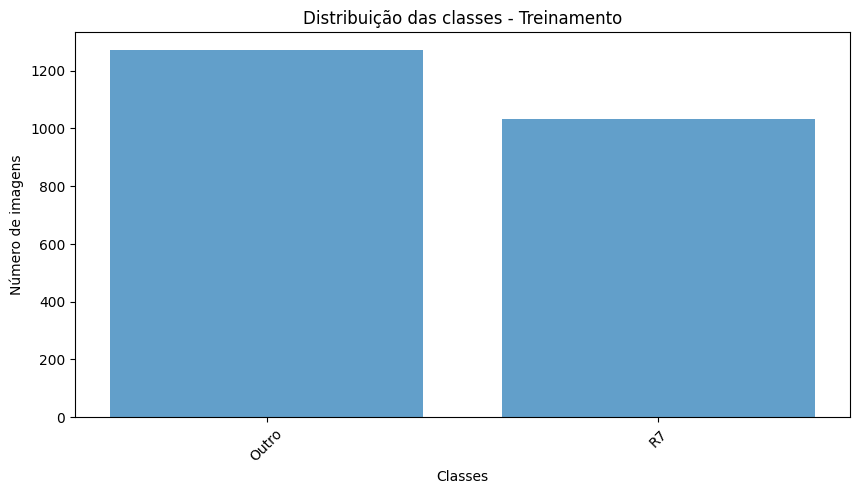

Distribuição das classes - Validação:
Outros: 1378
R7: 902


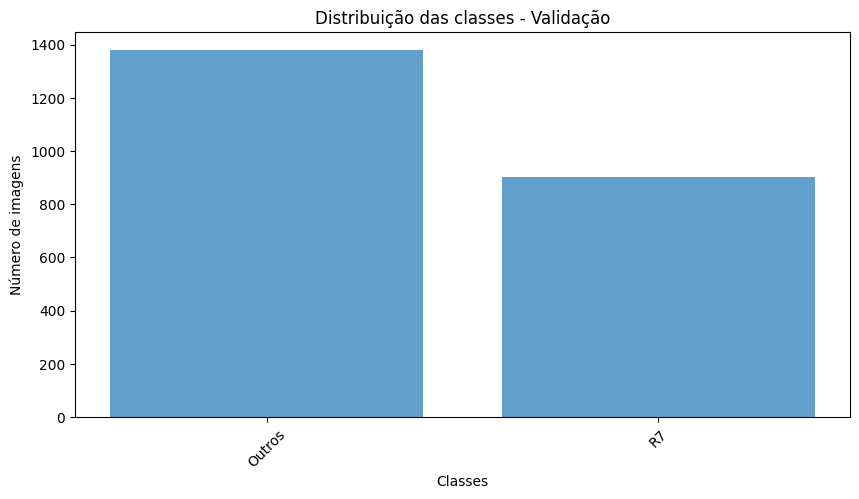

Pesos das classes: {0: 0.9059055118110236, 1: 1.1159068865179438}


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout, Conv2D,   GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Definindo as dimensões das imagens
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_dir = 'D:\\dataset\\train'
val_dir = 'D:\\dataset\\validation'
# Carregando e preparando o dataset (supondo que você tenha as pastas 'train' e 'val')
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical'
)

# Verificando a distribuição das classes
def plot_class_distribution(generator, title):
    class_counts = np.bincount(generator.classes)
    class_labels = list(generator.class_indices.keys())
    
    print(f"Distribuição das classes - {title}:")
    for label, count in zip(class_labels, class_counts):
        print(f"{label}: {count}")
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, class_counts, alpha=0.7)
    plt.xlabel("Classes")
    plt.ylabel("Número de imagens")
    plt.title(f"Distribuição das classes - {title}")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator, "Treinamento")
plot_class_distribution(val_generator, "Validação")

# Balanceamento das classes usando pesos
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Pesos das classes:", class_weight_dict)


Modelo 1: Rede Neural Inception3

In [2]:
def create_inceptionv3_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=train_generator.num_classes):
    # Carregar o modelo InceptionV3 pré-treinado com pesos do ImageNet, sem a camada de classificação final
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar as camadas do modelo base (InceptionV3)
    base_model.trainable = False
    
    # Criar o modelo sequencial
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Camada de pooling global para reduzir as dimensões
        Dense(512, activation='relu'),
        Dropout(0.4),  # Reduzir overfitting
        Dense(256, activation='relu'),
        Dropout(0.3),  # Mais dropout para regularização
        Dense(num_classes, activation='softmax')  # Camada de saída
    ])
    
    # Compilar o modelo
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Modelo 2: ResNet50

In [3]:
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Congela as primeiras camadas da ResNet para preservar os pesos pré-treinados
    base_model.trainable = False  

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    
    # Usa Adam com um learning rate menor para melhor estabilidade
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

Modelo 3: Vgg16

In [4]:
def create_vgg16_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=train_generator.num_classes):
    # Carregar o modelo VGG16 pré-treinado com pesos do ImageNet, sem a camada de classificação final
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar as camadas do modelo base (VGG16)
    base_model.trainable = False
    
    # Criar o modelo sequencial
    model = Sequential([
        base_model,
        Flatten(),  # Achatar as características extraídas pela VGG16
        Dense(512, activation='relu'),
        Dropout(0.4),  # Reduzir overfitting
        Dense(256, activation='relu'),
        Dropout(0.3),  # Mais dropout para regularização
        Dense(num_classes, activation='softmax')  # Camada de saída
    ])
    
    # Compilar o modelo
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [5]:
# Função para treinar e avaliar os modelos
def train_and_evaluate(model, train_generator, val_generator, epochs=5):
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator
    )
    return history

# Criando os modelos
models = {
    "Inceptionv3": create_inceptionv3_model(),
    "ResNet50": create_resnet_model(),
    "VGG16": create_vgg16_model()
}

# Treinando e avaliando os modelos
histories = {}
for name, model in models.items():
    print(f"Treinando o modelo: {name}")
    history = train_and_evaluate(model, train_generator, val_generator)
    histories[name] = history
    model.save(f"saved_models/{name}.h5")
    print(f"Modelo {name} salvo em {name}.h5")


Treinando o modelo: Inceptionv3


c:\Users\ViniciusTessele\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 723s 10s/step - accuracy: 0.7608 - loss: 0.4881 - val_accuracy: 0.6197 - val_loss: 0.8955
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 676s 9s/step - accuracy: 0.9297 - loss: 0.2006 - val_accuracy: 0.6531 - val_loss: 0.9169
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 681s 10s/step - accuracy: 0.9541 - loss: 0.1195 - val_accuracy: 0.6868 - val_loss: 0.8618
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 670s 9s/step - accuracy: 0.9747 - loss: 0.0775 - val_accuracy: 0.6996 - val_loss: 0.9736
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 669s 9s/step - accuracy: 0.9837 - loss: 0.0539 - val_accuracy: 0.7075 - val_loss: 0.9943


Modelo Inceptionv3 salvo em Inceptionv3.h5
Treinando o modelo: ResNet50
Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 699s 10s/step - accuracy: 0.7808 - loss: 0.6645 - val_accuracy: 0.3956 - val_loss: 0.7943
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 722s 10s/step - accuracy: 0.9079 - loss: 0.2362 - val_accuracy: 0.3961 - val_loss: 0.7528
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 717s 10s/step - accuracy: 0.9354 - loss: 0.1693 - val_accuracy: 0.4899 - val_loss: 0.6982
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 687s 10s/step - accuracy: 0.9422 - loss: 0.1416 - val_accuracy: 0.6618 - val_loss: 0.6091
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 683s 10s/step - accuracy: 0.9451 - loss: 0.1325 - val_accuracy: 0.7355 - val_loss: 0.5286


Modelo ResNet50 salvo em ResNet50.h5
Treinando o modelo: VGG16
Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 697s 10s/step - accuracy: 0.8106 - loss: 0.4198 - val_accuracy: 0.6627 - val_loss: 0.7622
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 698s 10s/step - accuracy: 0.9290 - loss: 0.1714 - val_accuracy: 0.6684 - val_loss: 1.1789
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 696s 10s/step - accuracy: 0.9666 - loss: 0.0896 - val_accuracy: 0.6904 - val_loss: 1.1565
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 695s 10s/step - accuracy: 0.9731 - loss: 0.0652 - val_accuracy: 0.7096 - val_loss: 1.1096
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 698s 10s/step - accuracy: 0.9872 - loss: 0.0415 - val_accuracy: 0.6930 - val_loss: 1.3182


Modelo VGG16 salvo em VGG16.h5


Coparando os Resultados

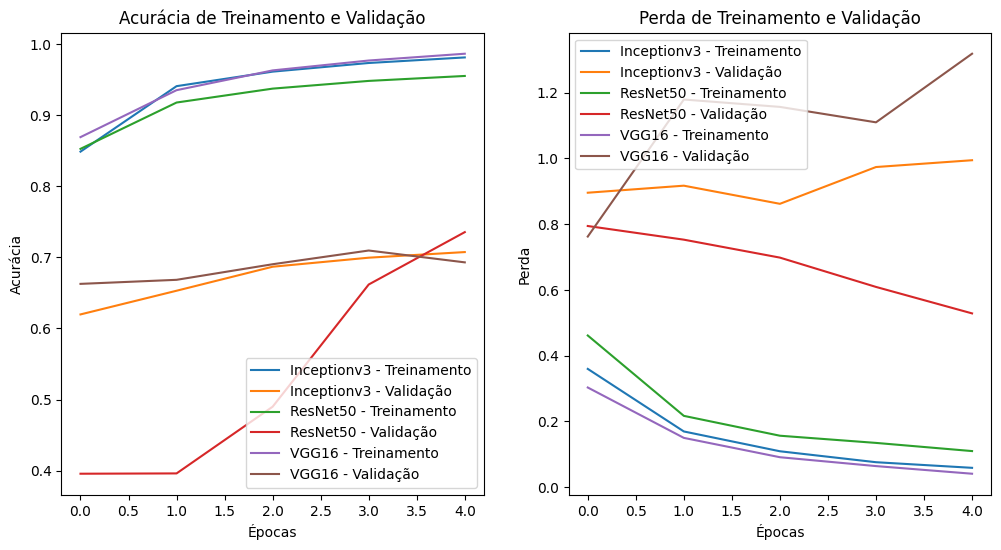

In [6]:
# Plotando as curvas de acurácia e perda para cada modelo
plt.figure(figsize=(12, 6))

# Acurácia
plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} - Treinamento')
    plt.plot(history.history['val_accuracy'], label=f'{name} - Validação')
plt.title('Acurácia de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} - Treinamento')
    plt.plot(history.history['val_loss'], label=f'{name} - Validação')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()


Gerando matriz de confusão para o modelo: Inceptionv3
72/72 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step


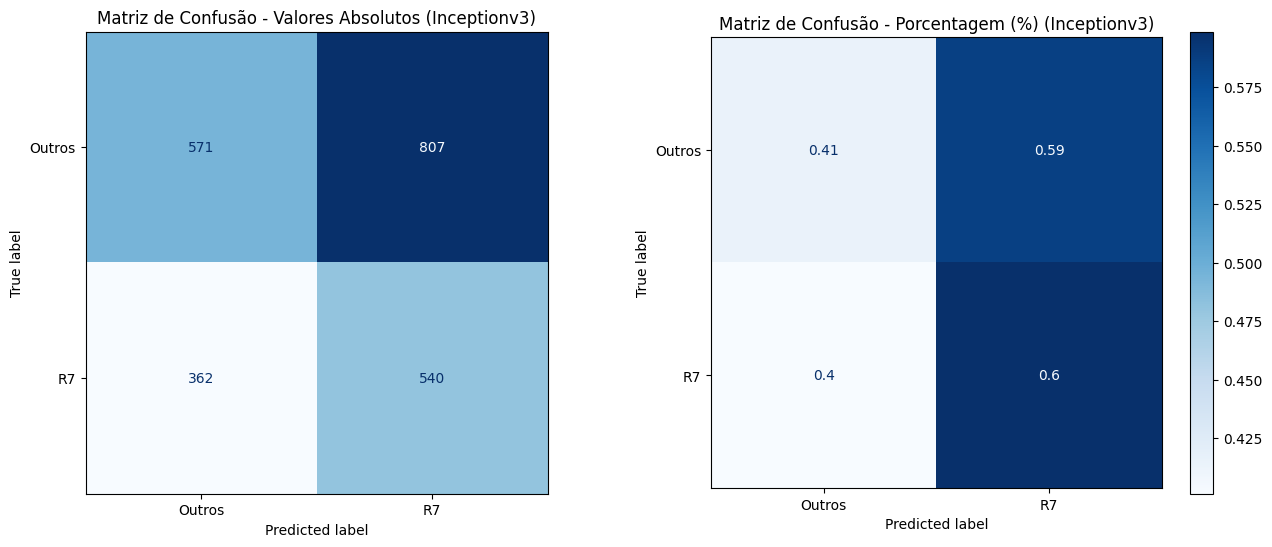


Gerando matriz de confusão para o modelo: ResNet50
72/72 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step


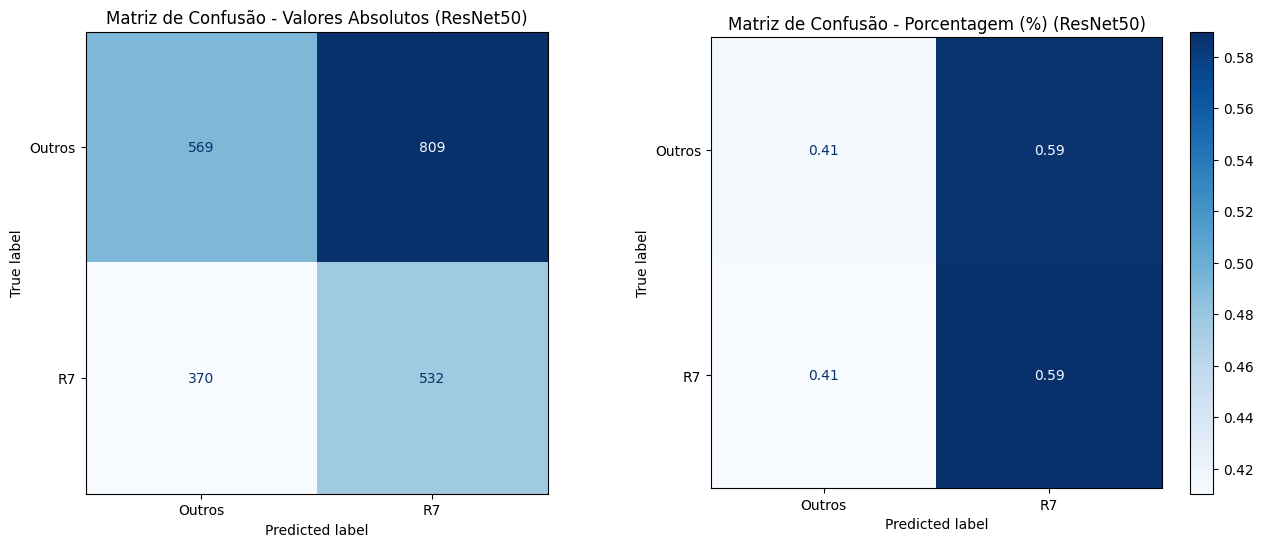


Gerando matriz de confusão para o modelo: VGG16
59/72 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step

In [ ]:
# Iterar sobre os modelos
for model_name, model in models.items():
    print(f"\nGerando matriz de confusão para o modelo: {model_name}")
    
    # Previsões no conjunto de validação
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_generator.classes

    # Matriz de confusão - Valores absolutos
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Criar figuras lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Matriz de confusão absoluta
    disp_abs = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
    disp_abs.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
    axes[0].set_title(f'Matriz de Confusão - Valores Absolutos ({model_name})')

    # Matriz de confusão normalizada
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=val_generator.class_indices.keys())
    disp_norm.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=True)
    axes[1].set_title(f'Matriz de Confusão - Porcentagem (%) ({model_name})')

    plt.show()


Explicação dos Modelos:
Densa (Fully Connected): Modelo simples e rápido de treinar, mas com desempenho limitado para tarefas complexas de visão computacional.
ResNet50: Modelo pré-treinado e mais poderoso para extração de características complexas, ideal para tarefas de imagem mais desafiadoras.
LSTM + CNN: Ideal para tarefas onde há uma sequência de imagens (como vídeos), pois captura dependências temporais entre as imagens.